<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Стохастический-градиентный-спуск" data-toc-modified-id="Стохастический-градиентный-спуск-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Стохастический градиентный спуск</a></span></li><li><span><a href="#BERT-с-логистической-регрессией" data-toc-modified-id="BERT-с-логистической-регрессией-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>BERT с логистической регрессией</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Оценка-моделей" data-toc-modified-id="Оценка-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Оценка моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Классификация комментариев пользователей сервиса интернет-магазина

Интернет-магазин «Викишоп» запускает новый сервис, где пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В проекте требуется построить модель классификации комментариев на позитивные и негативные со значением метрики качества *F1* не меньше 0.75. Нам предоставлен набор данных с разметкой о токсичности правок (файл toxic_comments.csv). Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Цель проекта**

Построить наилучшую модель для классификации комментариев на токсичные и нетоксичные, основываясь на размеченных данных.

**Задачи проекта**

1. Подготовить данные для анализа, обработать признаки, разделить на обучающую и тестовую выборки.
2. Исследовать базовые модели и рассмотреть, как меняются показатели оценки в зависимости от примененной модели. Подобрать гиперпараметры.
3. Выбрать наилучшую модель, по возможности доработать ее, учитывая дисбаланс классов. Проверить модели на тестовой выборке.

## Подготовка

In [1]:
pip install transformers

     |████████████████████████████████| 2.6 MB 8.6 MB/s 
     |████████████████████████████████| 895 kB 76.4 MB/s 
     |████████████████████████████████| 636 kB 63.8 MB/s 
     |████████████████████████████████| 3.3 MB 34.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import torch
import transformers
from transformers import BertTokenizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split, GridSearchCV
pd.options.mode.chained_assignment = None
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Загрузим файл и посмотрим на предоставленные данные.

In [3]:
comments = pd.read_csv('/content/toxic_comments.csv')
print(comments)

                                                     text  toxic
0       Explanation\nWhy the edits made under my usern...      0
1       D'aww! He matches this background colour I'm s...      0
2       Hey man, I'm really not trying to edit war. It...      0
3       "\nMore\nI can't make any real suggestions on ...      0
4       You, sir, are my hero. Any chance you remember...      0
...                                                   ...    ...
159566  ":::::And for the second time of asking, when ...      0
159567  You should be ashamed of yourself \n\nThat is ...      0
159568  Spitzer \n\nUmm, theres no actual article for ...      0
159569  And it looks like it was actually you who put ...      0
159570  "\nAnd ... I really don't think you understand...      0

[159571 rows x 2 columns]


Обучение на англоязычном корпусе.
Проверим, насколько сбалансирован наш датасет.

In [4]:
print(comments['toxic'].value_counts(normalize=True))

0    0.898321
1    0.101679
Name: toxic, dtype: float64


В предоставленном датасете около 90% правок не являются токсичными. Это значит, что существует значительный "перевес" в сторону "обычных" комментариев, их больше в 9 раз.

Посмотрим на типы данных и проверим датасет на наличие пропущенных значений.

In [5]:
print(comments.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


Типы данных корректны, пропущенных значений нет. Проверим, есть ли дубликаты.

In [6]:
print('Количество дубликатов в наборе данных: {}'.format(comments.duplicated().sum()))

Количество дубликатов в наборе данных: 0


Подготовим признаки. Приведем слова в комментариях к нижнему регистру и начальной форме (лемме). Для этого напишем функцию, которая будет принимать тексты сообщений и испытаем ее на маленьком фрагменте. Функция будет возвращать лемматизированный, очищенный от лишних символов, текст.

In [7]:
global nlp
def lemmatize(text):
    clear_text = " ".join(re.sub(r'[^a-zA-Z]', ' ', text.lower()).split())
    doc = nlp(clear_text)
    lemm_text = " ".join([token.lemma_ for token in doc])
    return re.sub(r'[-PRON-]', '', lemm_text)

print("Лемматизированный текст:", lemmatize(comments['text'][0]))

Лемматизированный текст: explanation why the edit make under  username hardcore metallica fan be revert  weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now


Применим функцию ко всей таблице.

In [8]:
#Wall time: 33min 34s
#%%time
comments['lemm_text'] = comments['text'].apply(lambda x: lemmatize(x))
print(comments.head())

                                                text  ...                                          lemm_text
0  Explanation\nWhy the edits made under my usern...  ...  explanation why the edit make under  username ...
1  D'aww! He matches this background colour I'm s...  ...  d aww  match this background colour i m seemin...
2  Hey man, I'm really not trying to edit war. It...  ...  hey man i m really not try to edit war  s just...
3  "\nMore\nI can't make any real suggestions on ...  ...  more i can t make any real suggestion on impro...
4  You, sir, are my hero. Any chance you remember...  ...   sir be  hero any chance  remember what page t...

[5 rows x 3 columns]


Разобъем датасет на обучающую и тестовую выборки. Размер тестовой выборки - 20%.

In [9]:
train, test = train_test_split(comments, test_size=0.20, stratify=comments['toxic'], random_state=12345)
print(train.shape, test.shape)

(127656, 3) (31915, 3)


Создадим корпус правок, преобразуем полученный столбец lemm_text в список текстов (пока для обучающей выборки). Поскольку текст английский, опустим перевод в юникод .astype('U') в целях экономии памяти.

In [10]:
corpus_train = train['lemm_text'].values#.astype('U')
print(corpus_train)

['actually move  here would be xenophrenic s preferred response as  can see above  ask for  to be here  foolishly believe that this process would lead to more scrutiny of  disruptive behavior  have unequivocally prove  wrong also  in the process i thank  for that talk'
 'bomb awwwaaaayyyyy wikipedia feature article candidate perseus constellation archive right with two of   should be able to kick this one over the line cheer talk contribs'
 'relation be this dale robert any relation to the also deceased dale roberts who be once a player and coach at ipswich town user talk sir stanley'
 ...
 'not how the level scale work for example if a player clear out a dungeon at level the enemy would be skeleton if the player return at level or above  could be full of troll the enemy weapon be also level along with the treasure the player can find in chest and on enemy body for one thing  s very rare and near impossible to find troll at level four secondly troll would never ever replace skeleton be

Создадим мешок слов и отбросим стоп-слова.

In [11]:
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))
count_vect = CountVectorizer(stop_words=stop_words)
bow = count_vect.fit_transform(corpus_train)

print("Размер мешка с учётом стоп-слов:", bow.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Размер мешка с учётом стоп-слов: (127656, 134646)


Оценим важность слов величиной TF-IDF. Посчитаем TF-IDF для корпуса текстов, вызвав функцию fit_transform() для обучающей выборки.

In [12]:
vect = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = vect.fit_transform(corpus_train)
print("Размер матрицы:", tf_idf_train.shape)

Размер матрицы: (127656, 134646)


Разделим обучающий датасет на набор признаков и целевой признак.

In [13]:
features_train = tf_idf_train
target_train = train['toxic']
print(features_train.shape, target_train.shape)

(127656, 134646) (127656,)


Аналогичным образом обработаем и набор данных для тестирования. Только для TF-IDF используем transform().

In [14]:
corpus_test = test['lemm_text'].values
tf_idf_test = vect.transform(corpus_test)

print("Размер матрицы:", tf_idf_test.shape)

features_test = tf_idf_test
target_test = test['toxic']
print(features_test.shape, target_test.shape)

Размер матрицы: (31915, 134646)
(31915, 134646) (31915,)


### Вывод

В предоставленном для исследования датасете не выявлено пропущенных значений и дубликатов. Типы данных корректны. 

Примерно 90% комментариев не являются токсичными, имеется явный дисбаланс в сторону "обычных" текстов, их больше в 9 раз.

Для подготовки к обучению все слова в комментариях приведены к нижнему регистру и начальной форме (лемме). Датасет разбит на обучающую и тестовую выборки, из них исключены стоп-слова и рассчитан TF-IDF.

## Обучение

В проекте рассмотрено 4 модели: логистическая регрессия, дерево решений, случайный лес и стохастический градиентный спуск.

Оптимальные гиперпараметры будем подбирать с помощью функции GridSearchCV(). Поскольку перебирать гиперпараметры мы будем не один раз, объявим функцию для подбора этих гиперпараметров. На вход она будет принимать перечень параметров, тип модели, набор обучающих признаков, обучающий целевой признак, а также словарь и название модели для сохранения результирующей метрики.

Возвращать функция будет метрику F1. Количество подвыборок для кросс-валидации укажем 3 (cv=3). Это позволит, с одной стороны, объективнее оценить итоги отдельно не выделяя валидационную выборку, а с другой - не очень большое количество подвыборок ускорит процесс подбора гиперпараметров.

In [15]:
def select_params(params, model, features, target, dictionary, name):
    mod = GridSearchCV(model, params, cv=3, scoring='f1')
    %time mod.fit(features, target)
    f1 = mod.best_score_
    print('f1_score:', f1)
    if name in dictionary:
        if dictionary[name] < f1:
            dictionary[name] = f1
    else:
        dictionary[name] = f1
    print(mod.best_params_)

In [16]:
f1_valid = {}

### Логистическая регрессия

Первой моделью изучим логистическую регрессию. Выведем f1-score, какое получается, если не "докручивать" модель, а использовать гиперпараметры, установленные по умолчанию.

Используем нашу функцию для подбора параметров, т.к. она основана на кросс-валидации (нет необходимости проверять результат на валидационной выборке, позже используем сразу тестовую). Просто передадим ей пустые параметры.

In [17]:
params = {}
select_params(params, LogisticRegression(), features_train, target_train, f1_valid, 'Logistic Regression')

CPU times: user 24.7 s, sys: 26.8 s, total: 51.5 s
Wall time: 26.5 s
f1_score: 0.7137094740721658
{}


Теперь попробуем поменять гиперпараметы и посмотрим, улучшится ли результат.

In [18]:
params = {'penalty': ['l1', 'l2'], 'class_weight': ['balanced'],
         'solver': ['liblinear', 'saga']}
select_params(params, LogisticRegression(), features_train, target_train, f1_valid, 'Logistic Regression')

CPU times: user 13min, sys: 4.13 s, total: 13min 4s
Wall time: 12min 57s
f1_score: 0.7580365174512126
{'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}


Качество модели явно стало лучше. Сохраним модель с полученными гиперпараметрами.

In [19]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1', class_weight='balanced')
model_lr.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

### Дерево решений

Рассмотрим дерево решений.

In [20]:
params = {}
select_params(params, DecisionTreeClassifier(), features_train, target_train, f1_valid, 'Decision Tree')

CPU times: user 14min 46s, sys: 587 ms, total: 14min 46s
Wall time: 14min 43s
f1_score: 0.7107374845919053
{}


Попробуем доработать модель.

In [21]:
params = {'max_depth': [6, 8, 10], 'min_samples_leaf': [2,4], 'class_weight': ['balanced']}
select_params(params, DecisionTreeClassifier(), features_train, target_train, f1_valid, 'Decision Tree')

CPU times: user 2min 44s, sys: 208 ms, total: 2min 44s
Wall time: 2min 43s
f1_score: 0.5687581769483562
{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4}


Качество модели намного ухудшилось. Сохраним нашу модель с первоначальными гиперпараметрами в переменной model_dt.

In [22]:
%%time
model_dt = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_dt.fit(features_train, target_train)

CPU times: user 2min 5s, sys: 90.2 ms, total: 2min 5s
Wall time: 2min 4s


### Случайный лес

Рассмотрим модель случайного леса. Сначала с гиперпараметрами по умолчанию.

In [23]:
params = {}
select_params(params, RandomForestClassifier(), features_train, target_train, f1_valid, 'Random Forest')

CPU times: user 42min 56s, sys: 2.51 s, total: 42min 59s
Wall time: 42min 47s
f1_score: 0.6842775546323981
{}


Попробуем внести изменения в модель.

In [24]:
params = {'max_depth': [6, 8, 10], 'n_estimators': [60, 90], 'class_weight': ['balanced']}
select_params(params, RandomForestClassifier(), features_train, target_train, f1_valid, 'Random Forest')

CPU times: user 3min 9s, sys: 800 ms, total: 3min 9s
Wall time: 3min 9s
f1_score: 0.35646293766674714
{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 90}


Признаем, что до нашего вмешательства модель классифицировала гораздо лучше. Оставим гиперпараметры "из коробки", только укажем class_weight='balanced'.

In [25]:
%%time
model_rf = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_rf.fit(features_train, target_train)

CPU times: user 9min 53s, sys: 491 ms, total: 9min 53s
Wall time: 9min 50s


### Стохастический градиентный спуск

Еще одна модель, которая рассматривается в проекте - стохастический градиентный спуск. По аналогии с предыдущими моделями - сначала гиперпараметры не меняем, посмотрим на базовое значение метрики. Потом попробуем изменить.

In [26]:
params = {}
select_params(params, SGDClassifier(), features_train, target_train, f1_valid, 'SGDClassifier')

CPU times: user 924 ms, sys: 432 ms, total: 1.36 s
Wall time: 860 ms
f1_score: 0.6354345456637479
{}


In [27]:
params = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'], 'penalty': ['l2', 'l1'], 'alpha':[0.0001, 0.01, 1, 100], 'class_weight': ['balanced']}
select_params(params, SGDClassifier(), features_train, target_train, f1_valid, 'SGDClassifier')

CPU times: user 3min 28s, sys: 10.6 s, total: 3min 39s
Wall time: 3min 25s
f1_score: 0.7525714959398173
{'alpha': 0.0001, 'class_weight': 'balanced', 'loss': 'modified_huber', 'penalty': 'l2'}


С подобранными гиперпараметрами модель работает определенно лучше. Сохраним в переменной model_sgd.

In [28]:
model_sgd = SGDClassifier(loss='modified_huber', random_state=12345, class_weight='balanced', penalty='l1')
model_sgd.fit(features_train, target_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=12345, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### BERT с логистической регрессией

Попробуем классифицировать правки на основе векторных представлений слов. Текстов много, поэтому используем небольшой фрагмент данных. Поскольку существует сильный дисбаланс класов, то наблюдения в выборку будем набирать не случайно, а сделаем "квоты", по 50% для каждого типа комментария. 

In [29]:
comments_zeros = comments[comments['toxic'] == 0]
comments_ones = comments[comments['toxic'] == 1]

comments_1 = pd.concat([comments_zeros.sample(n=200, random_state=12345)] + [comments_ones.sample(n=200, random_state=12345)])
comments_1 = shuffle(comments_1, random_state=12345)

Проверим, корректно ли отобрались классы.

In [30]:
print(comments_1.shape)
print(comments_1['toxic'].value_counts())

(400, 3)
1    200
0    200
Name: toxic, dtype: int64


Разобьем на слова и преобразуем их в список токенов. Для этого инициализируем токенизатор.

In [31]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Преобразуем текст в номера токенов. Чтобы при создании эмбеддингов не возникало ошибки, ограничим максимальную длину вектора - 512.

In [32]:
tokenized = comments_1['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

Применим метод padding и создадим маску для важных токенов.

In [33]:
max_len = 512
        
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

Инициализируем конфигурацию BertConfig, затем инициализируем саму модель класса BertModel. Передадим ей файл с предобученной моделью и конфигурацией.

In [34]:
config = transformers.BertConfig.from_pretrained('bert-base-uncased') 
model_b = transformers.BertModel.from_pretrained('bert-base-uncased', config = config)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Преобразуем тексты в эмбеддинги.

In [35]:
batch_size = 20
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    with torch.no_grad():
        batch_embeddings = model_b(batch, attention_mask=attention_mask_batch)
        
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

Соберём все эмбеддинги в матрицу признаков. Также выделим вектор с целевым признаком и разобьем данные на обучающую и тестовую выборки.

In [36]:
features_b = np.concatenate(embeddings)
target_b= comments_1['toxic']

features_train_b, features_test_b, target_train_b, target_test_b = train_test_split(features_b, target_b, test_size=0.2, random_state=12345)

Воспользуемся функцией подбора гиперпараметров и выведем f1_score модели.

In [37]:
params = {}
select_params(params, LogisticRegression(), features_train_b, target_train_b, f1_valid, 'BERT + Logistic Regression')

CPU times: user 368 ms, sys: 224 ms, total: 592 ms
Wall time: 320 ms
f1_score: 0.8554112554112554
{}


Сохраняем в переменной model_lr_b.

In [38]:
model_lr_b = LogisticRegression()
model_lr_b.fit(features_train_b, target_train_b)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Вывод

В работе рассмотрено 4 модели, одна из них (логистическая регрессия) как на основе оценок TF-IDF, так и на основе эмбеддингов. В сочетании с оценкой важности слов TF-IDF из них пороговое значение (f1_score = 0.75) преодолели только две: логистическая регрессия и стохастический градиентный спуск. Логистическая регрессия на основе эмбеддингов (BERT) продемонстрировала довольно высокий результат f1 = 0.86.

Теперь проверим эффективность моделей на тестовой выборке.

## Оценка моделей

Для оценки эффективности моделей напишем функцию для вывода основных метрик.

In [39]:
def compare_table(models, features, features2, target, target2, f1_v):
    df = pd.DataFrame(columns=['models', 'accuracy', 'recall', 'precision', 'f1-score_test', 'f1-score_valid'])
    for name, model in models.items():
        if name == 'BERT + Logistic Regression':
            prediction = model.predict(features2)
            accur = accuracy_score(target2, prediction).round(3)
            rec = recall_score(target2, prediction).round(3)
            prec = precision_score(target2, prediction).round(3)
            f1 = f1_score(target2, prediction).round(3)
            rv = f1_v[name]
        else:
            prediction = model.predict(features)
            accur = accuracy_score(target, prediction).round(3)
            rec = recall_score(target, prediction).round(3)
            prec = precision_score(target, prediction).round(3)
            f1 = f1_score(target, prediction).round(3)
            rv = f1_v[name]
        df = df.append({'models': name, 'accuracy': accur, 'recall': rec, 'precision': prec, 'f1-score_test': f1, 'f1-score_valid': rv}, ignore_index=True)
    return df

Для передачи функции создадим список с моделями.

In [40]:
models_list = {'Logistic Regression': model_lr, 'Decision Tree': model_dt, 
                 'Random Forest': model_rf, 'SGDClassifier': model_sgd, 
               'BERT + Logistic Regression': model_lr_b}

Выведем основные метрики.

In [41]:
display('test', compare_table(models_list, features_test, features_test_b, target_test, target_test_b, f1_valid))

'test'

,models,accuracy,recall,precision,f1-score_test,f1-score_valid
0,Logistic Regression,0.946,0.865,0.684,0.764,0.758037
1,Decision Tree,0.927,0.721,0.620,0.667,0.710737
2,Random Forest,0.945,0.482,0.957,0.641,0.684278
3,SGDClassifier,0.920,0.858,0.571,0.686,0.752571
4,BERT + Logistic Regression,0.900,0.842,0.941,0.889,0.855411


Далее посмотрим, где именно наша модель логистической регрессии ошиблась (тем более, в датасете существует дисбаланс классов). Для этого построим матрицу ошибок по тестовой выборке.

Сначала рассмотрим модель на основе TF-IDF.

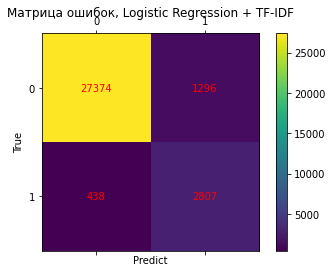

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm_ax = ax.matshow(confusion_matrix(target_test, model_lr.predict(features_test)))
plt.title('Матрица ошибок, Logistic Regression + TF-IDF')
fig.colorbar(cm_ax)
plt.xlabel('Predict')
plt.ylabel('True')

for i in range(len(confusion_matrix(target_test, model_lr.predict(features_test)))):
    for j in range(len(confusion_matrix(target_test, model_lr.predict(features_test)))):
        text = ax.text(j, i, confusion_matrix(target_test, model_lr.predict(features_test))[i, j],
                       ha="center", va="center", color="r")

Получилось довольно большое количество ложноположительных ответов. Это значит, что модель слишком часто ошибается в пользу менее распространенного "токсичного" класса.

Теперь посмотрим на матрицу ошибок для модели на основе эмбеддингов.

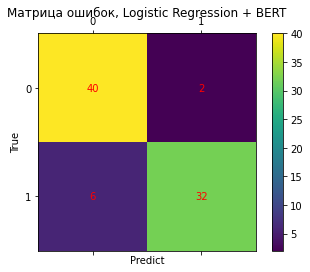

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm_ax = ax.matshow(confusion_matrix(target_test_b, model_lr_b.predict(features_test_b)))
plt.title('Матрица ошибок, Logistic Regression + BERT')
fig.colorbar(cm_ax)
plt.xlabel('Predict')
plt.ylabel('True')

for i in range(len(confusion_matrix(target_test_b, model_lr_b.predict(features_test_b)))):
    for j in range(len(confusion_matrix(target_test_b, model_lr_b.predict(features_test_b)))):
        text = ax.text(j, i, confusion_matrix(target_test_b, model_lr_b.predict(features_test_b))[i, j],
                       ha="center", va="center", color="r")

Здесь, наоборот, больше ложноотрицательных ответов. Это значит, что модель немного чаще определяет комментарии, как нетоксичные. Но нужно учесть, что вывод может быть неточным из-за довольно малого количества наблюдений в тестовой выборке.

### Вывод

Как показала проверка на тестовой выборке, пороговое значение f1 перешагнула только логистическая регрессия. Остальные метрики у нее тоже выше. Отметим тот факт, что значение precision у модели на основе TF-IDF чуть меньше, чем recall. Это значит, что модель выдает чуть больше ложноположительных результатов (т.е. чаще признает нормальные комментарии токсичными), чем нужно. 
Обратная ситуация с логистической регрессией в комбинации с BERT: precision выше recall.

## Общий вывод

В работе рассмотрено несколько моделей бинарной классификации. Лучший итог с TF-IDF выдала взвешенная логистическая регрессия, f1-score = 0.753 на валидационной выборке и 0.760 на тестовой). Модель немного завышает recall относительно precision. Это значит, что у нас будет много положительных ответов (в т.ч. и ложно) и мы "зачерпнем" много текстов, которые не являются токсичными.

Скорее всего, здесь необходимо исходить из того, насколько нам важно выделять токсичные комментарии и вовремя обращать на них внимание. В первом случае, возможно, не так уж и плохо, что модель "перестраховывается": пользователи сервиса не будут видеть негатив и обсценную лексику, а репутация сервиса не пострадает. Во втором - есть риск завалить модераторов лишней работой.

Логистическая регрессия в комбинации с BERT дала еще более высокие результаты: f1 = 0.855 на валидационной выборке и 0.889 на тестовой. Однако нужно учесть тот факт, что обучение и тестирование производилось на сильно усеченной выборке, хоть и сбалансированной по классам.